In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                      GridSearchCV, StratifiedKFold)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc)
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 14)
plt.rcParams['font.size'] = 10

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

try:
    df_raw = pd.read_csv('../data/cleaned/hcmhouseprice.csv')
    print("Loaded from CSV file")

    # ===== EDA: tính giá trung bình theo quận =====
    location_value = df_raw.groupby('address')['price'].mean()
    df_raw['location_value'] = df_raw['address'].map(location_value)

    # ===== Tạo feature mới =====
    df_raw['area_location'] = df_raw['area'] * df_raw['location_value']

    le = LabelEncoder()
    df_raw['address_code'] = le.fit_transform(df_raw['address'])

    # ===== Chọn features và target =====
    feature_cols = ['area', 'bedrooms', 'bathrooms', 'area_location', 'address_code']
    X = df_raw[feature_cols].values
    y = df_raw['price'].values

    # ===== Tạo object tương tự Iris =====
    class HcmHousePriceData:
        data = X
        target = y
        feature_names = feature_cols
        target_name = "price"

    price = HcmHousePriceData()

except FileNotFoundError:
    print("CSV not found — kiểm tra lại tên file và đường dẫn!")

# ===== Tạo DataFrame preview =====
df = pd.DataFrame(price.data, columns=price.feature_names)
df["price"] = price.target

print("Dataset loaded successfully!")
print(f"  Total samples: {len(df)}")
print(f"  Total features: {price.data.shape[1]}")
print(f"  Target column: price\n")

print("Dataset Preview:")
print(df.head(10))

print("\nDataset Information:")
print(f"  Shape: {df.shape}")
print(f"  Dtypes:\n{df.dtypes}")
print(f"  Missing values: {df.isnull().sum().sum()}")
print(f"  Duplicate rows: {df.duplicated().sum()}")


Loaded from CSV file
Dataset loaded successfully!
  Total samples: 2406
  Total features: 5
  Target column: price

Dataset Preview:
   area  bedrooms  bathrooms  area_location  address_code  price
0  58.1       1.0        1.0    1473.173472           7.0   20.6
1  56.0       1.0        1.0    1419.926239           7.0   20.0
2  51.0       1.0        1.0    1293.147110           7.0    8.9
3  50.0       1.0        1.0    1267.791284           7.0    9.5
4  48.0       1.0        1.0    1217.079633           7.0   10.2
5  52.0       1.0        1.0     835.664772          11.0    8.5
6  64.0       1.0        1.0    1028.510488          11.0   13.7
7  60.0       1.0        1.0     964.228583          11.0    7.3
8  55.0       1.0        0.0     883.876201          11.0    7.0
9  64.0       1.0        1.0    1028.510488          11.0   11.3

Dataset Information:
  Shape: (2406, 6)
  Dtypes:
area             float64
bedrooms         float64
bathrooms        float64
area_location    float64
a

===== Exploratory Data Analysis =====

1. Statistical Summary for Numeric Features:
            area  bedrooms  bathrooms  area_location  address_code     price
count   2406.000  2406.000   2406.000       2406.000      2406.000  2406.000
mean     121.007     2.828      2.498       1169.377        11.815     9.558
std     1359.996     3.413      3.408      11710.958         5.541    14.186
min        1.000     1.000      0.000          6.355         0.000     0.001
25%       65.000     2.000      2.000        357.483         8.000     3.150
50%       75.920     2.000      2.000        583.953        12.000     5.400
75%      100.000     3.000      2.000       1210.472        17.000    10.500
max    66666.000    60.000     60.000     573414.731        21.000   210.000


2. Price Distribution Summary:
  Price 0.001: 3 (0.1%)
  Price 0.002: 1 (0.0%)
  Price 0.003: 2 (0.1%)
  Price 0.005: 3 (0.1%)
  Price 0.007: 3 (0.1%)
  Price 0.009: 1 (0.0%)
  Price 0.017: 1 (0.0%)
  Price 0.0362: 1 (0.0

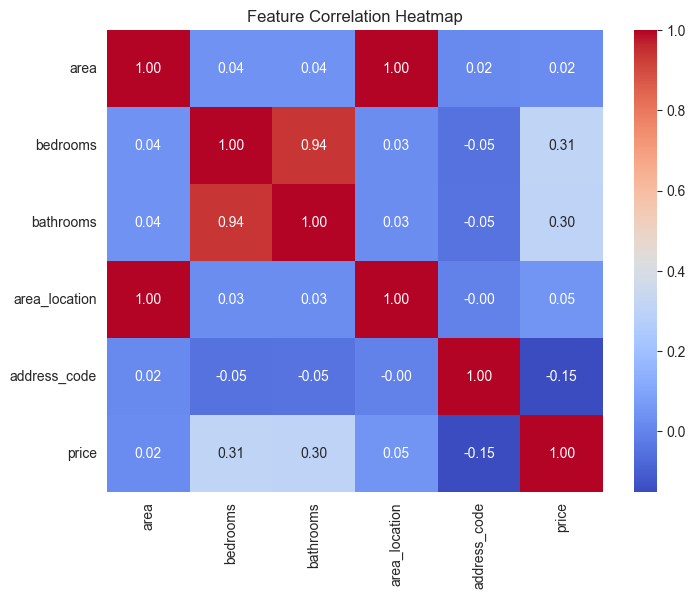

In [3]:
# ===== EXPLORATORY DATA ANALYSIS (EDA) =====
print("===== Exploratory Data Analysis =====\n")

df['address_code'] = pd.to_numeric(df['address_code'], errors='coerce')

# 1. Statistical Summary cho numeric features
print("1. Statistical Summary for Numeric Features:")
numeric_cols = ['area', 'bedrooms', 'bathrooms', 'area_location', 'address_code', 'price']
print(df[numeric_cols].describe().round(3))
print("\n")

# 2. Price distribution (histogram-style summary)
print("2. Price Distribution Summary:")
price_counts = df['price'].value_counts().sort_index()
for price, count in price_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Price {price}: {count} ({percentage:.1f}%)")
print("\n")

# 3. Outlier Detection using IQR method
print("3. Outlier Detection (IQR Method):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"  {col}: {len(outliers)} outliers detected ({len(outliers)/len(df)*100:.2f}%)")
print("\n")

# 4. Feature Correlation Analysis
print("4. Correlation Matrix:")
corr_matrix = df[numeric_cols].corr()
print(corr_matrix.round(3))
print("\n")

# Optional: visualize correlation matrix with seaborn
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()
except ImportError:
    print("Seaborn/matplotlib not installed — skipping correlation heatmap.")


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ===== Check for missing values =====
print(f"Missing values in dataset: {df.isnull().sum().sum()}\n")

# ===== Feature selection =====
feature_cols = ['area', 'bedrooms', 'bathrooms', 'area_location', 'address_code']
X = df[feature_cols].values
y = df['price'].values

# ===== Feature scaling =====
scaler_standard = StandardScaler()
X_scaled = scaler_standard.fit_transform(X)

print(f"✓ Features scaled using StandardScaler")
print(f"  • Feature means: {X_scaled.mean(axis=0).round(3)}")
print(f"  • Feature stds: {X_scaled.std(axis=0).round(3)}\n")

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

print(f"Train-Test Split:")
print(f"  • Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)\n")

# ===== Optional: quick check of target stats =====
print(f"Training set price range: {y_train.min()} - {y_train.max()}")
print(f"Testing set price range: {y_test.min()} - {y_test.max()}")


Missing values in dataset: 0

✓ Features scaled using StandardScaler
  • Feature means: [-0.  0. -0. -0.  0.]
  • Feature stds: [1. 1. 1. 1. 1.]

Train-Test Split:
  • Training set: 1684 samples (70.0%)
  • Testing set: 722 samples (30.0%)

Training set price range: 0.001 - 210.0
Testing set price range: 0.003 - 180.0


In [5]:
# MODEL TRAINING & HYPERPARAMETER TUNING
# Define CV strategy


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score


# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
lr_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Perform GridSearchCV
lr_grid = GridSearchCV(
    LinearRegression(),
    lr_params,
    cv=cv,
    scoring='r2',
    n_jobs=-1
)

# Fit model
lr_grid.fit(X_train, y_train)

# Extract best model
lr_best = lr_grid.best_estimator_

# Display results
print(f"  Best parameters: {lr_grid.best_params_}")
print(f"  Best CV R² Score: {lr_grid.best_score_:.4f}")

# Train final model
lr_best.fit(X_train, y_train)
print("  Linear Regression model trained successfully")

  Best parameters: {'fit_intercept': True, 'positive': True}
  Best CV R² Score: 0.4603
  Linear Regression model trained successfully


In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predict on train & test sets
y_train_pred = lr_best.predict(X_train)
y_test_pred = lr_best.predict(X_test)

# Evaluate model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Print performance summary
print(f"Training Performance:")
print(f"  R² Score:   {train_r2:.4f}")
print(f"  MAE:        {train_mae:.2f}")
print(f"  MSE:        {train_mse:.2f}")
print(f"  RMSE:       {train_rmse:.2f}")

print("\nTesting Performance:")
print(f"  R² Score:   {test_r2:.4f}")
print(f"  MAE:        {test_mae:.2f}")
print(f"  MSE:        {test_mse:.2f}")
print(f"  RMSE:       {test_rmse:.2f}")

# Summary table
results = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'R² Score': [train_r2, test_r2],
    'MAE': [train_mae, test_mae],
    'MSE': [train_mse, test_mse],
    'RMSE': [train_rmse, test_rmse]
})
print("\nPerformance Summary Table:")
print(results.round(4))

Training Performance:
  R² Score:   0.5004
  MAE:        4.41
  MSE:        106.50
  RMSE:       10.32

Testing Performance:
  R² Score:   -292.0016
  MAE:        12.14
  MSE:        50636.70
  RMSE:       225.03

Performance Summary Table:
     Set  R² Score      MAE         MSE      RMSE
0  Train    0.5004   4.4118    106.4973   10.3198
1   Test -292.0016  12.1390  50636.6964  225.0260


✓ Dashboard saved as 'house_price_dashboard.png'


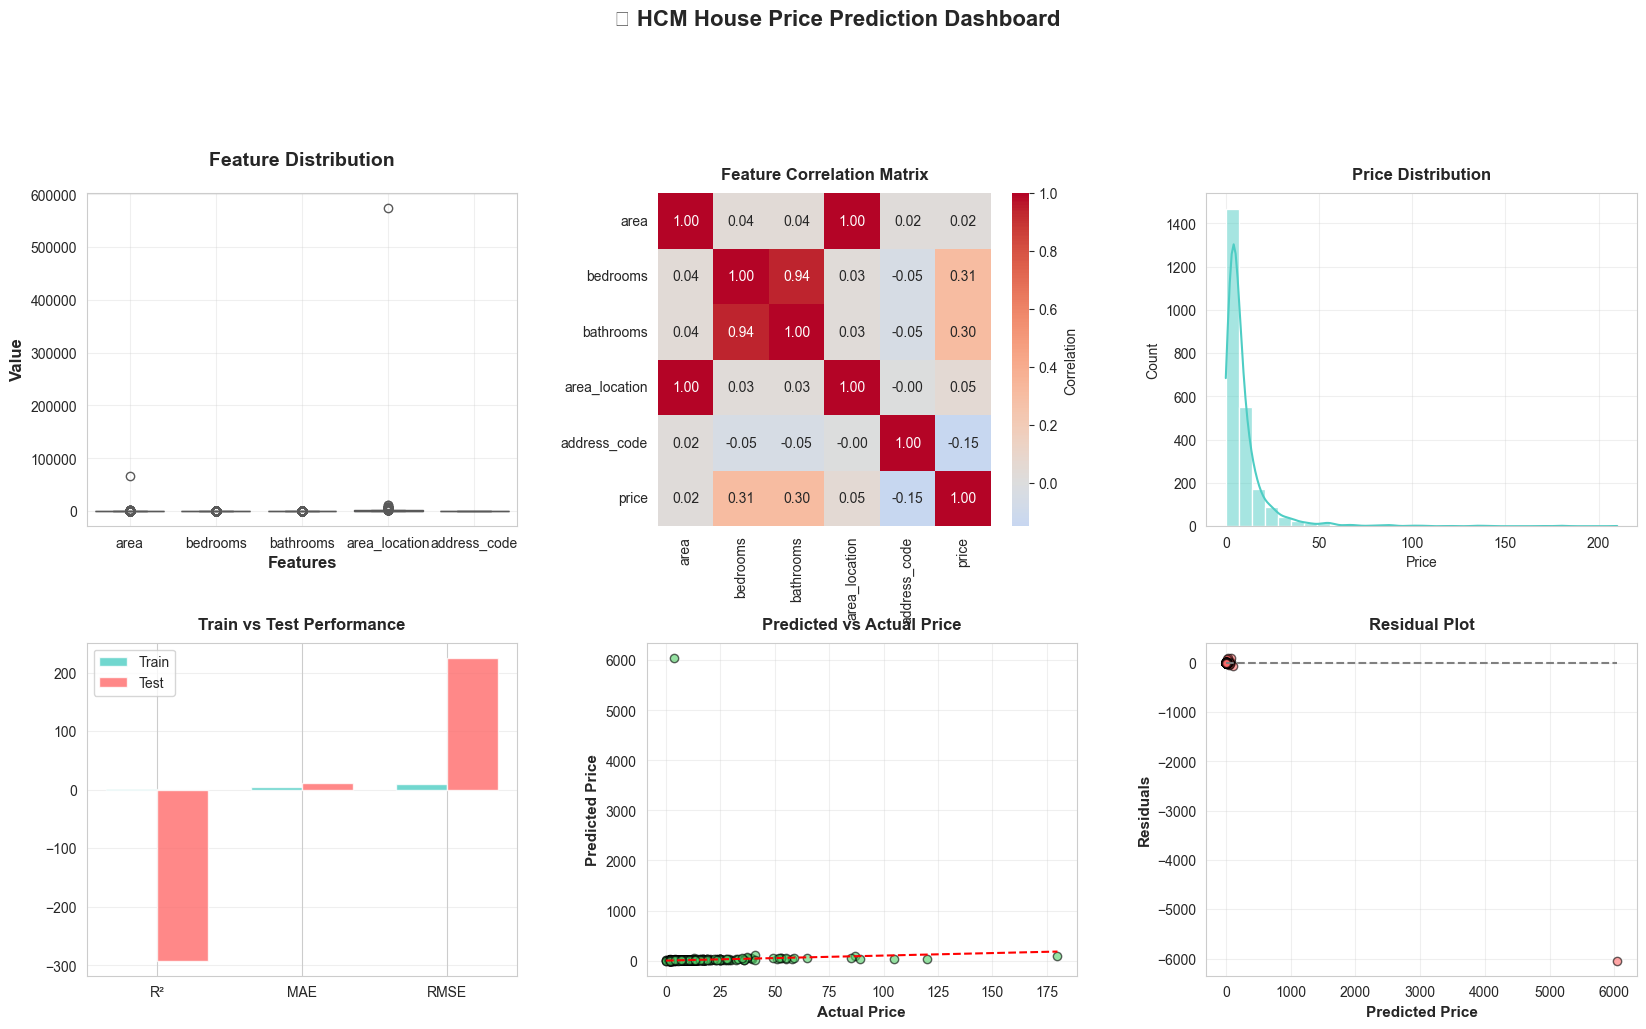

In [7]:
# house_price_visualization.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Giả sử bạn đã có các biến từ mô hình =====
# df, feature_cols, y_train, y_test, y_train_pred, y_test_pred
# train_r2, test_r2, train_mae, test_mae, train_rmse, test_rmse

# ===============================
# 1. Create Figure & Grid
# ===============================
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ===============================
# Chart 1: Feature Distribution (Boxplot)
# ===============================
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df[feature_cols], palette='Set2', ax=ax1)
ax1.set_title('Feature Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('Value', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# ===============================
# Chart 2: Correlation Heatmap
# ===============================
ax2 = fig.add_subplot(gs[0, 1])
corr_data = df[feature_cols + ['price']].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True,
            ax=ax2, cbar_kws={'label': 'Correlation'})
ax2.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold', pad=10)

# ===============================
# Chart 3: Price Distribution
# ===============================
ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(df['price'], bins=30, kde=True, color='#4ECDC4', ax=ax3)
ax3.set_title('Price Distribution', fontsize=12, fontweight='bold', pad=10)
ax3.set_xlabel('Price')
ax3.set_ylabel('Count')
ax3.grid(alpha=0.3)

# ===============================
# Chart 4: Train vs Test Metrics
# ===============================
ax4 = fig.add_subplot(gs[1, 0])
metrics_names = ['R²', 'MAE', 'RMSE']
train_metrics = [train_r2, train_mae, train_rmse]
test_metrics = [test_r2, test_mae, test_rmse]

x_pos = np.arange(len(metrics_names))
width = 0.35
ax4.bar(x_pos - width/2, train_metrics, width, label='Train', color='#4ECDC4', alpha=0.8)
ax4.bar(x_pos + width/2, test_metrics, width, label='Test', color='#FF6B6B', alpha=0.8)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics_names)
ax4.set_title('Train vs Test Performance', fontsize=12, fontweight='bold', pad=10)
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# ===============================
# Chart 5: Predicted vs Actual Price
# ===============================
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(y_test, y_test_pred, alpha=0.6, color='#51CF66', edgecolor='black')
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax5.set_xlabel('Actual Price', fontsize=11, fontweight='bold')
ax5.set_ylabel('Predicted Price', fontsize=11, fontweight='bold')
ax5.set_title('Predicted vs Actual Price', fontsize=12, fontweight='bold', pad=10)
ax5.grid(alpha=0.3)

# ===============================
# Chart 6: Residuals Plot
# ===============================
ax6 = fig.add_subplot(gs[1, 2])
residuals = y_test - y_test_pred
ax6.scatter(y_test_pred, residuals, alpha=0.6, color='#FF6B6B', edgecolor='black')
ax6.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), linestyles='dashed', colors='gray')
ax6.set_xlabel('Predicted Price', fontsize=11, fontweight='bold')
ax6.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax6.set_title('Residual Plot', fontsize=12, fontweight='bold', pad=10)
ax6.grid(alpha=0.3)


# ===============================
# Layout & Save
# ===============================
plt.suptitle('🏠 HCM House Price Prediction Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('house_price_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard saved as 'house_price_dashboard.png'")
plt.show()


In [ ]:

# PREDICTION ON NEW DATA (House Prices)
# Example: new house data
# Cột: ['area', 'bedrooms', 'bathrooms', 'area_location', 'address_code']
new_houses = np.array([
    [70, 2, 2, 70*1000, 0],  # ví dụ nhà 70m2 ở quận code 0
    [120, 3, 2, 120*1200, 5], # nhà 120m2 quận 5
    [50, 1, 1, 50*900, 2]     # nhà 50m2 quận 2
])

# Scale features
new_houses_scaled = scaler_standard.transform(new_houses)

# Make predictions
pred_prices = lr_best.predict(new_houses_scaled)

# Print results
print("\nNew House Price Predictions:\n")
print(f"{'Area':<6} {'Bedrooms':<9} {'Bathrooms':<10} {'Area*Location':<15} {'Address_Code':<12} {'Predicted Price'}")
print("-" * 90)
for i, house in enumerate(new_houses):
    print(f"{house[0]:<6} {house[1]:<9} {house[2]:<10} {house[3]:<15.1f} {house[4]:<12} {pred_prices[i]:.2f}")



New House Price Predictions:

Area   Bedrooms  Bathrooms  Area*Location   Address_Code Predicted Price (million VND)
------------------------------------------------------------------------------------------
70     2         2          70000.0         0            737.79
120    3         2          144000.0        5            1518.08
50     1         1          45000.0         2            474.03
